# Initialize

In [1]:
import distutils.util
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

print('Installing dm_control...')
#!pip install -q dm_control>=1.0.8

# Configure dm_control to use the EGL rendering backend (requires GPU)
%env MUJOCO_GL=egl

print('Checking that the dm_control installation succeeded...')
try:
    from dm_control import suite
    env = suite.load('cartpole', 'swingup')
    pixels = env.physics.render()
except Exception as e:
    raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')
else:
    del pixels, suite

!echo Installed dm_control $(pip show dm_control | grep -Po "(?<=Version: ).+")

# %pip -q install git+https://github.com/deepmind/acme.git#egg=dm-acme[jax,tf,envs]
# %pip -q install imageio-ffmpeg
# %pip -q install gdown

IMG_HEIGHT = 256
IMG_WIDTH = 256
# Removed unnecessary generated file
! rm -r "=1.0.8"

import os
import random
import math
import pickle
import numpy as np
import tree
# plot the activations
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import imageio
from PIL import Image
import io

from sklearn.decomposition import PCA


import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal
from torch.optim import Adam

#Run to install MuJoCo and `dm_control`
# import this first to resolve the issue.
import sys
sys.path.insert(1, '../source/')
from acme import wrappers
from model import *
from utils import *
# Soft-Actor-Critic Model
from sac import *
from replay_memory import *

# try out the wrappers
from acme import wrappers
from dm_control import suite


Sun Dec  4 14:58:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.39.01    Driver Version: 510.39.01    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:3B:00.0 Off |                    0 |
| N/A   37C    P0    44W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/opt/miniconda3/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Environment wrappers

In [2]:
#@title Environment wrappers
from dm_env import specs


# environment wrappers
class NormilizeActionSpecWrapper(wrappers.EnvironmentWrapper):
    """Turn each dimension of the actions into the range of [-1, 1]."""

    def __init__(self, environment):
        super().__init__(environment)

        action_spec = environment.action_spec()
        self._scale = action_spec.maximum - action_spec.minimum
        self._offset = action_spec.minimum

        minimum = action_spec.minimum * 0 - 1.
        maximum = action_spec.minimum * 0 + 1.
        self._action_spec = specs.BoundedArray(
            action_spec.shape,
            action_spec.dtype,
            minimum,
            maximum,
            name=action_spec.name)

    def _from_normal_actions(self, actions):
        actions = 0.5 * (actions + 1.0)  # a_t is now in the range [0, 1]
        # scale range to [minimum, maximum]
        return actions * self._scale + self._offset

    def step(self, action):
        action = self._from_normal_actions(action)
        return self._environment.step(action)

    def action_spec(self):
        return self._action_spec


class MujocoActionNormalizer(wrappers.EnvironmentWrapper):
    """Rescale actions to [-1, 1] range for mujoco physics engine.

    For control environments whose actions have bounded range in [-1, 1], this
      adaptor rescale actions to the desired range. This allows actor network to
      output unscaled actions for better gradient dynamics.
    """

    def __init__(self, environment, rescale='clip'):
        super().__init__(environment)
        self._rescale = rescale

    def step(self, action):
        """Rescale actions to [-1, 1] range before stepping wrapped environment."""
        if self._rescale == 'tanh':
            scaled_actions = tree.map_structure(np.tanh, action)
        elif self._rescale == 'clip':
            scaled_actions = tree.map_structure(lambda a: np.clip(a, -1., 1.), action)
        else:
            raise ValueError('Unrecognized scaling option: %s' % self._rescale)
        return self._environment.step(scaled_actions)



## Helper functions Moved to `utils.py`

## Environment and agent setup

**NOTE: Make sure you download the pretrained weights or upload your own weights before running this cell!**

In [3]:
# download the pretrained weights
#https://drive.google.com/file/d/13Xug1PoJ3bl3Ya9MTM0p-AR513mtsIVR/view?usp=share_link

In [4]:
# load the environment
env = suite.load(domain_name="cheetah", task_name="run")
# add wrappers onto the environment
env = NormilizeActionSpecWrapper(env)
env = MujocoActionNormalizer(environment=env, rescale='clip')
env = wrappers.SinglePrecisionWrapper(env)


class Args:
    env_name = 'whatever'
    policy = 'Gaussian'
    eval = True
    gamma = 0.99
    tau = 0.005
    lr = 0.0003
    alpha = 0.2
    automatic_entropy_tuning = True
    seed = 42
    batch_size = 256
    num_steps = 1000000
    hidden_size = 256
    updates_per_step = 1
    start_steps = 10000
    target_update_interval = 1
    replay_size = 1000000
    # use the cuda to speedup
    cuda = True


args = Args()

# get the dimensionality of the observation_spec after flattening
flat_obs = tree.flatten(env.observation_spec())
# combine all the shapes
obs_dim = sum([item.shape[0] for item in flat_obs])

# setup agent, using Soft-Actor-Critic Model
agent = SAC(obs_dim, env.action_spec(), args)
# load checkpoint - UPLOAD YOUR FILE HERE!
model_path = 'sac_checkpoint_cheetah_123456_10000'
agent.load_checkpoint(model_path, evaluate=True)

# pull out model
model = agent.policy
# setup hook dict
hook_dict = init_hook_dict(model)
# add hooks
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Linear):
        module.register_forward_hook(recordtodict_hook(name=name, hook_dict=hook_dict))

Loading models from sac_checkpoint_cheetah_123456_10000


## Collecting activations and kinematics

In [5]:
CHEETAH_GEOM_NAMES = ['ground', 'torso', 'head', 'bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin', 'ffoot']
CHEETAH_JOINT_NAMES = ['bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin', 'ffoot']
CHEETAH_ACTUATOR_NAMES = ['bthigh', 'bshin', 'bfoot', 'fthigh', 'fshin', 'ffoot']

# get the mapping of the geom names
geom_names_to_idx = {geom_name: idx for idx, geom_name in enumerate(CHEETAH_GEOM_NAMES)}
# get the mapping of the joint names
joint_names_to_idx = {joint_name: idx for idx, joint_name in enumerate(CHEETAH_JOINT_NAMES)}
# get the mapping of the actuator names
actuator_names_to_idx = {actuator_name: idx for idx, actuator_name in enumerate(CHEETAH_ACTUATOR_NAMES)}

In [6]:
# run a few episodes just to collect activations
num_episodes_to_run = 42

# for recording kinematics
total_kinematic_dict = {
    'geom_positions': [],
    'joint_angles': [],
    'joint_velocities': [],
    'actuator_forces': []
}

for i in range(num_episodes_to_run):
    time_step = env.reset()
    episode_reward = 0
    while not time_step.last():  # or env.get_termination()
        # get the state
        state = get_flat_obs(time_step)
        # sample an action
        action = agent.select_action(state)
        time_step = env.step(action)

        # record kinematics
        kinematic_dict = get_kinematics(env.physics, CHEETAH_GEOM_NAMES, CHEETAH_JOINT_NAMES, CHEETAH_ACTUATOR_NAMES)
        total_kinematic_dict['geom_positions'].append(kinematic_dict['geom_positions'])
        total_kinematic_dict['joint_angles'].append(kinematic_dict['joint_angles'])
        total_kinematic_dict['joint_velocities'].append(kinematic_dict['joint_velocities'])
        total_kinematic_dict['actuator_forces'].append(kinematic_dict['actuator_forces'])
        # record reward
        episode_reward += time_step.reward
    if i % 10 == 0:
        print('Episode: {} Reward: {}'.format(i+1, episode_reward))

Episode: 1 Reward: 917.8360124323517
Episode: 11 Reward: 917.503063518554
Episode: 21 Reward: 921.8676992543042
Episode: 31 Reward: 913.8624752759933
Episode: 41 Reward: 918.2549227681011


In [7]:
#### optional: save + load the hook_dict
# save_path = 'hook_dict.npy'
# save_hook_dict(hook_dict, save_path)
#
# load_path = 'hook_dict.npy'
# loaded_hook_dict = load_hook_dict(load_path)


In [8]:
# otherwise, just compile the hook_dict
loaded_hook_dict = compile_hook_dict(hook_dict)

In [9]:
# process the kinematics - convert the kinematics to numpy arrays
total_kinematic_dict['geom_positions'] = np.stack(total_kinematic_dict['geom_positions'],
                                                  axis=0)  # combine the geom_positions_arr into (t, n, 3)
total_kinematic_dict['joint_angles'] = np.array(total_kinematic_dict['joint_angles'])
total_kinematic_dict['joint_velocities'] = np.array(total_kinematic_dict['joint_velocities'])
total_kinematic_dict['actuator_forces'] = np.array(total_kinematic_dict['actuator_forces'])

In [10]:
# example 1: get the joint angles for the bthigh
bthigh_joint_angles = total_kinematic_dict['joint_angles'][:, joint_names_to_idx['bthigh']]

# example 2: get the geom positions for the torso
torso_geom_positions = total_kinematic_dict['geom_positions'][:, geom_names_to_idx['torso'], :]

## Example: Using PCA to visualize activations

In [11]:
loaded_hook_dict["linear1"].shape

(42000, 256)

In [12]:
# do pca on the activations
pca_dict = {}
for name, arr in loaded_hook_dict.items():
    pca = PCA(n_components=2)
    pca.fit(arr)
    pca_dict[name] = pca

In [13]:
#### optional: save + load the pca_dict
# save_path = 'pca_dict.npy'
# save_pca_dict(pca_dict, save_path)
# loaded_pca_dict = load_pca_dict(save_path)

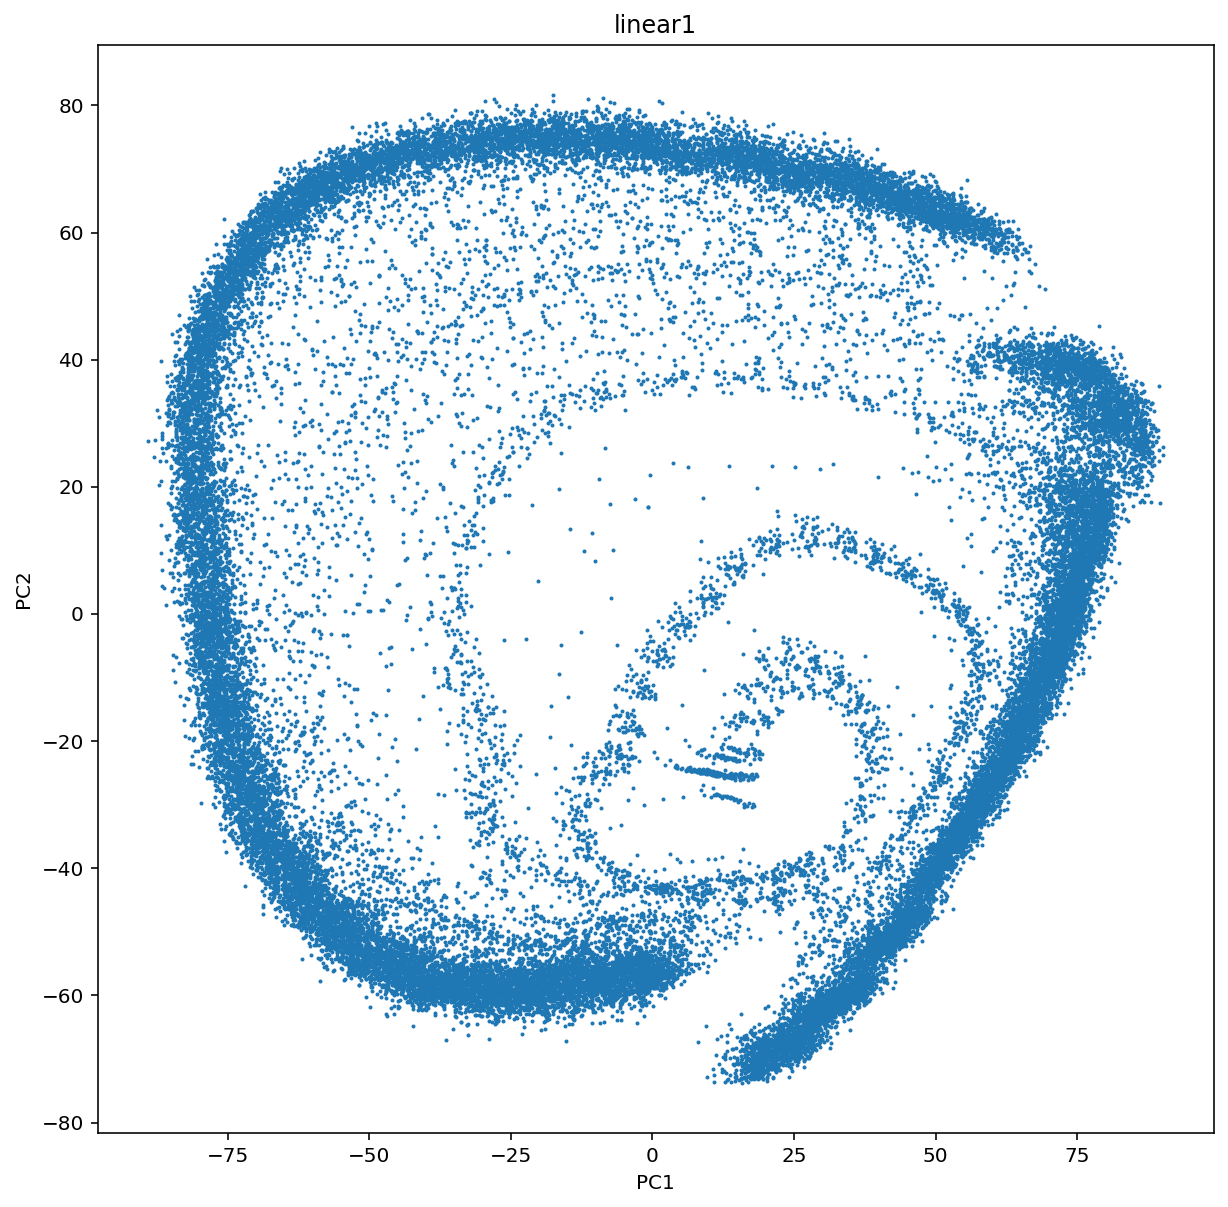

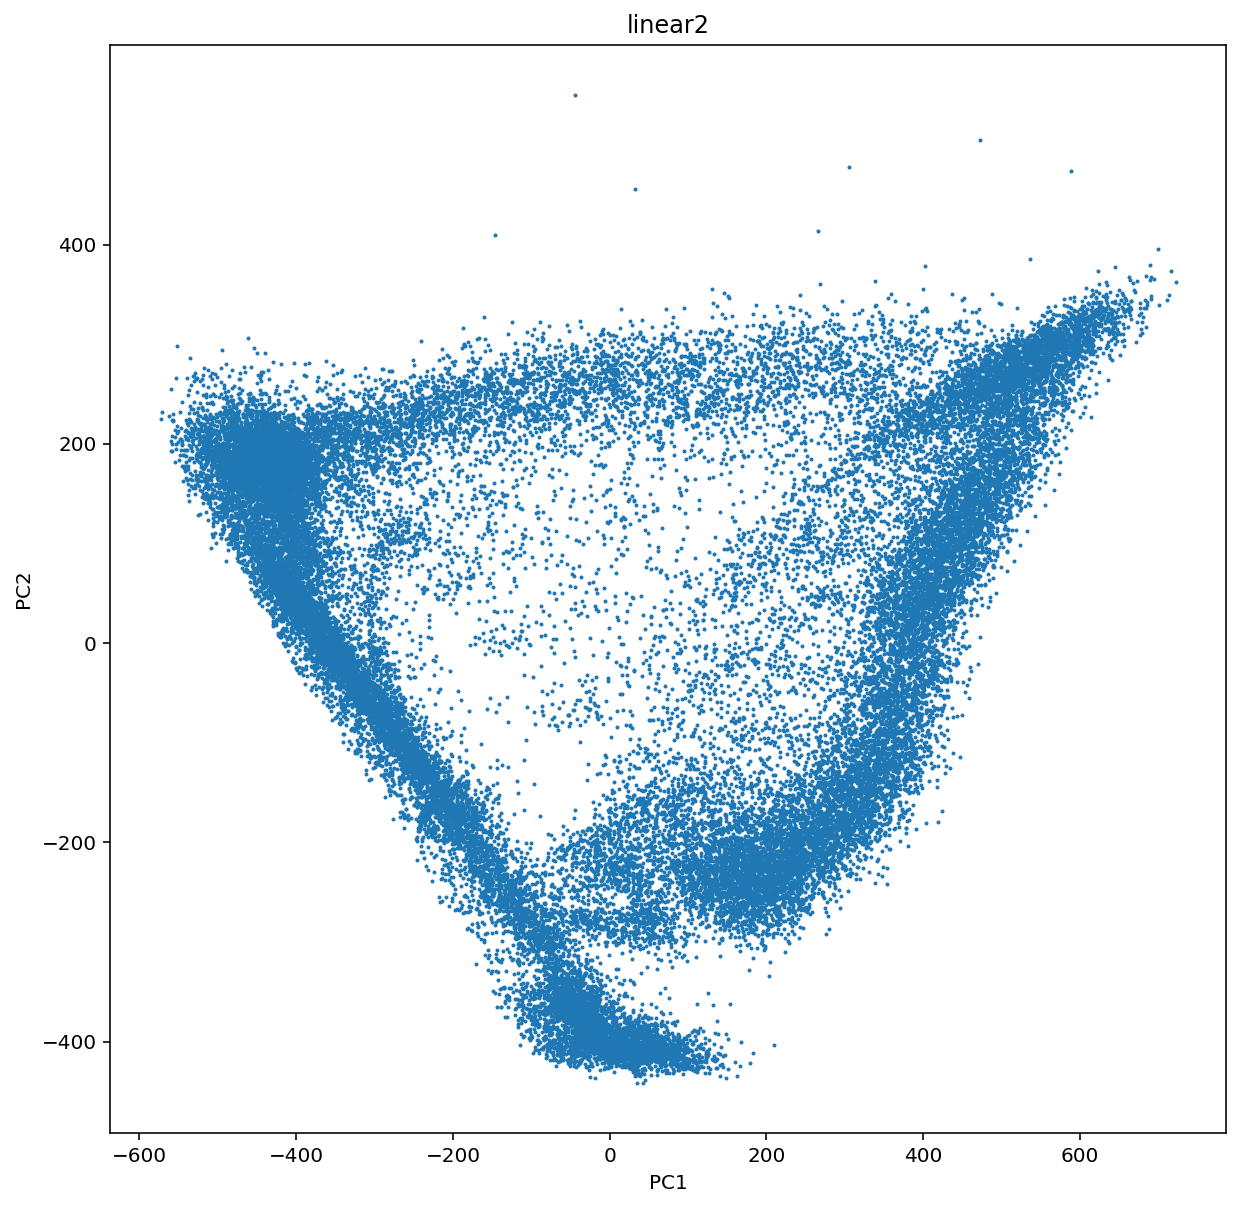

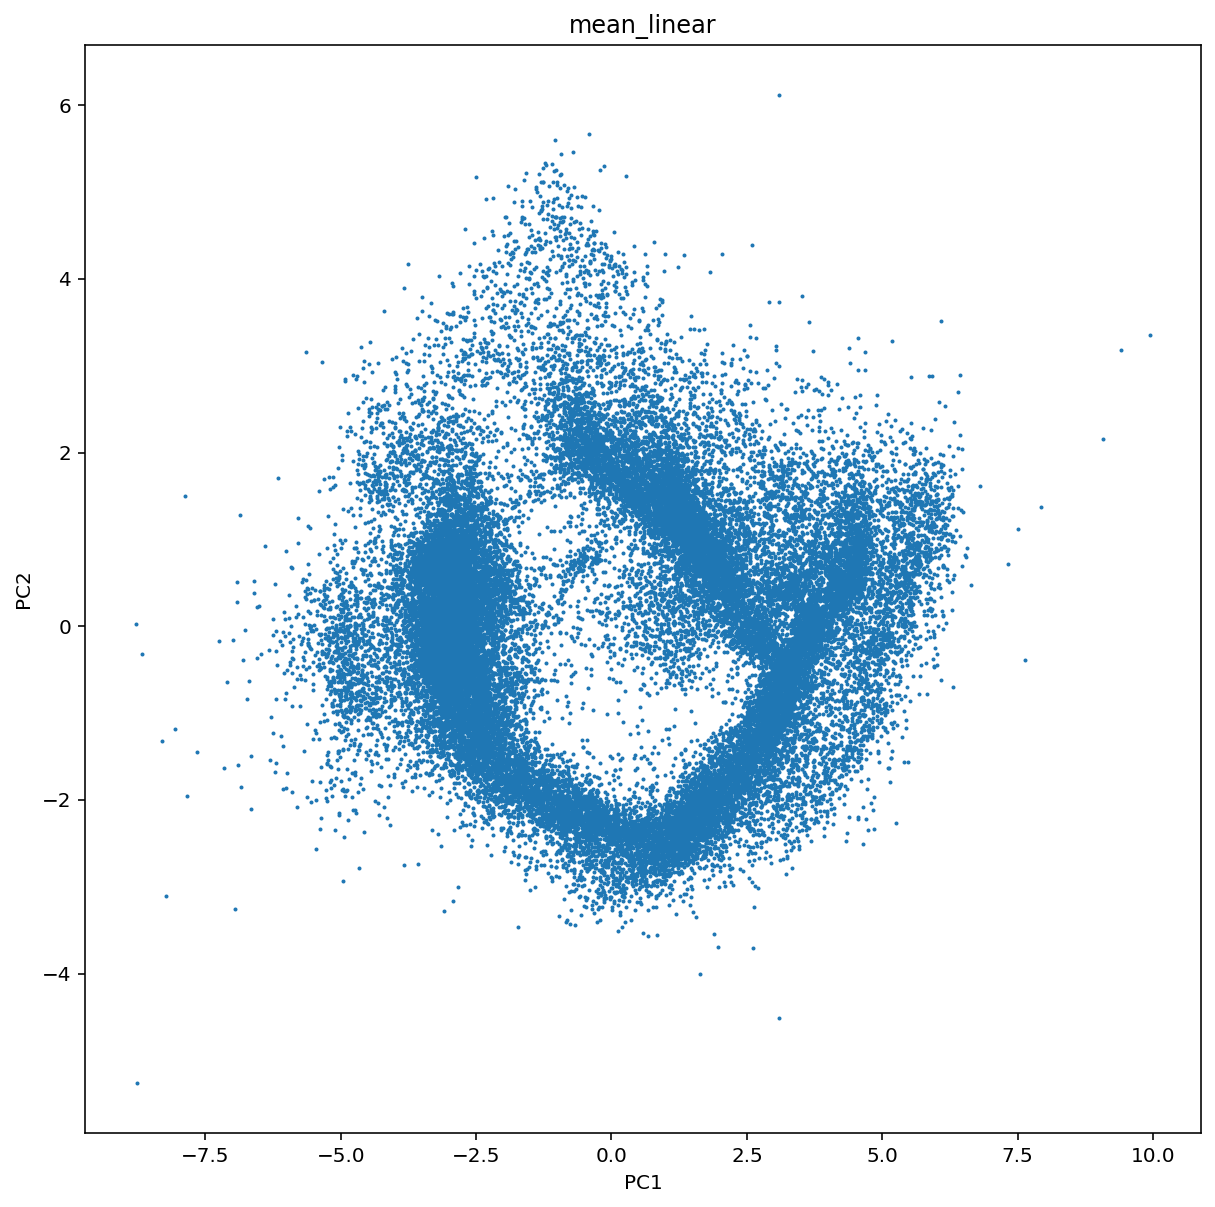

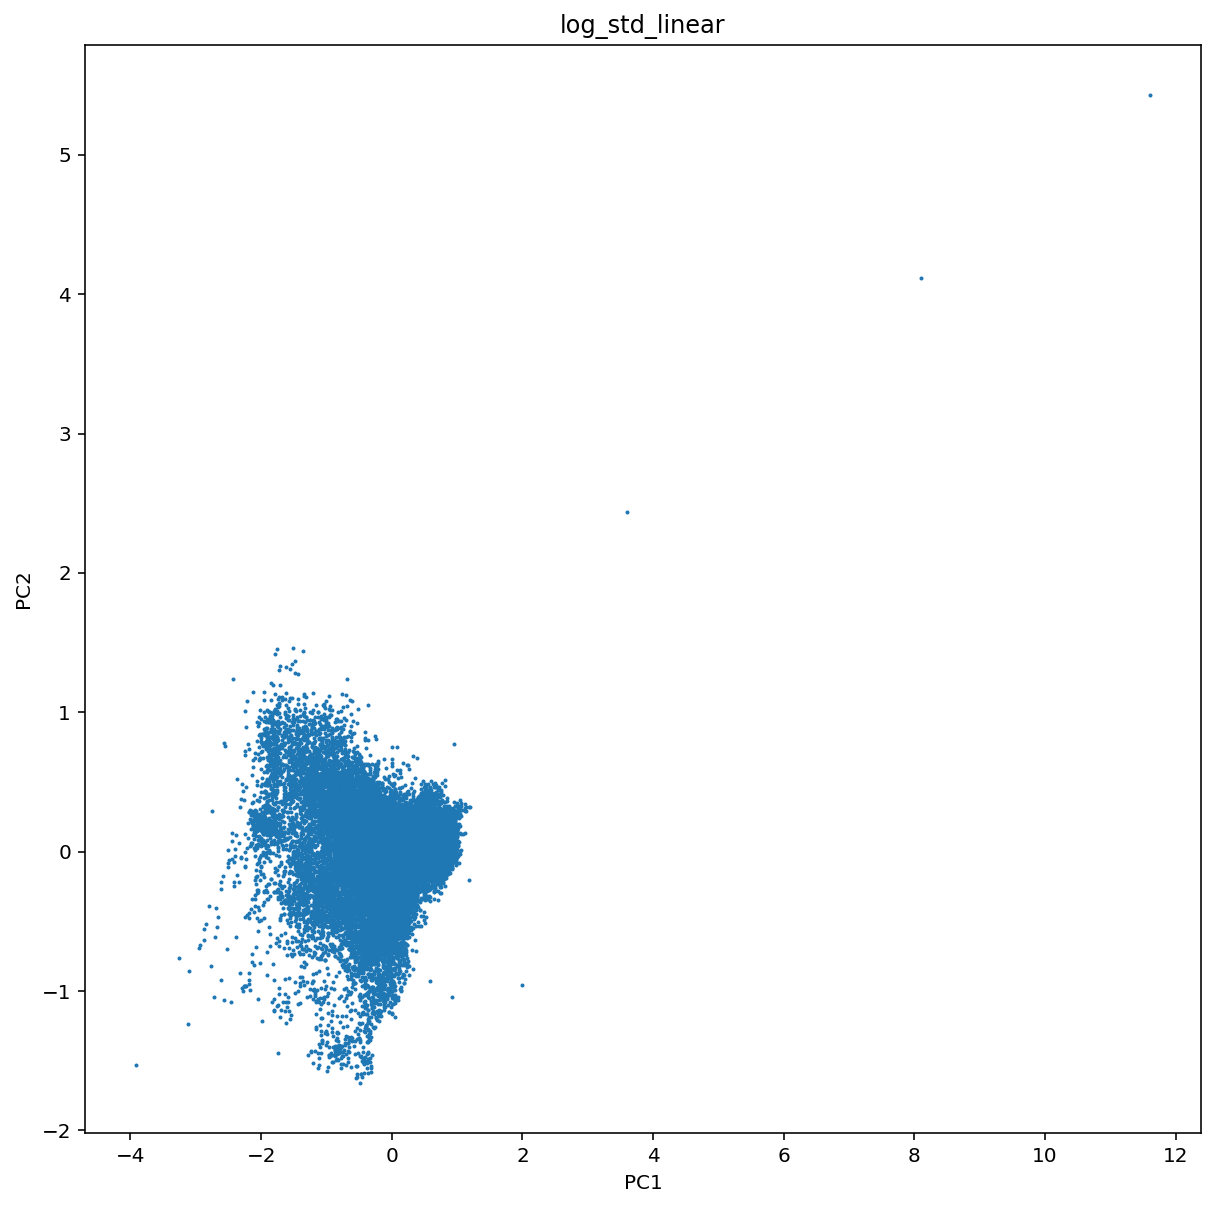

In [14]:
%matplotlib inline
# plot the activations, and save the activations to a dictionary
os.makedirs('activations', exist_ok=True)

activations_dict = {}
for name, pca in pca_dict.items():
    # get activations
    activations = get_activations(pca_dict=pca_dict, compiled_hook_dict=loaded_hook_dict, layer_name=name)

    # save activations
    activations_dict[name] = activations

    # plot activations
    save_path = 'activations/{}.png'.format(name)
    fig_im = plot_activations(activations, layer_name=name, save_path=save_path, show=True)

## Example: Using Power Spectral Density to visualize activations

In [15]:
# filter the activations_dict to only include the layers we want
layers_to_include = ['linear1', 'linear2']

# get the activations for the layers we want
filtered_activations = {k: v for k, v in loaded_hook_dict.items() if k in layers_to_include}

# split the activations by the number of episodes collected (assumes all episodes have the same number of steps)
# get the number of steps per episode
num_steps_per_episode = activations_dict['linear1'].shape[0] // num_episodes_to_run

In [16]:
!pip install scipy --upgrade

Defaulting to user installation because normal site-packages is not writeable


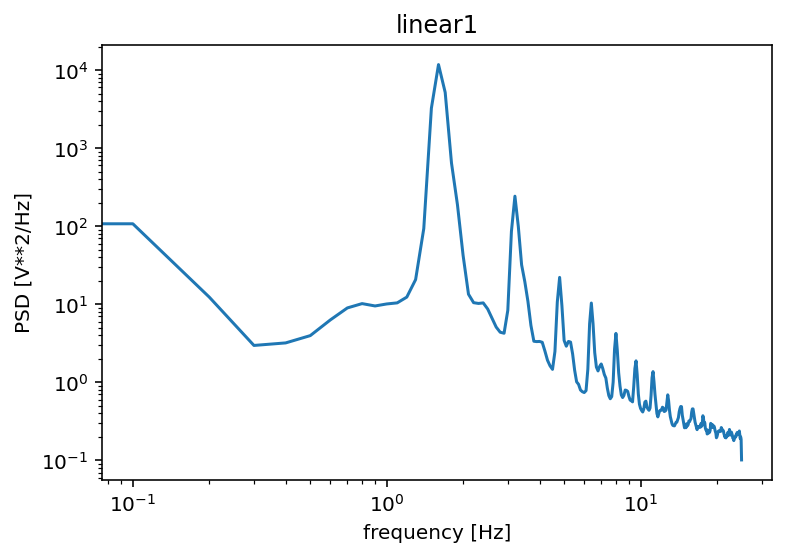

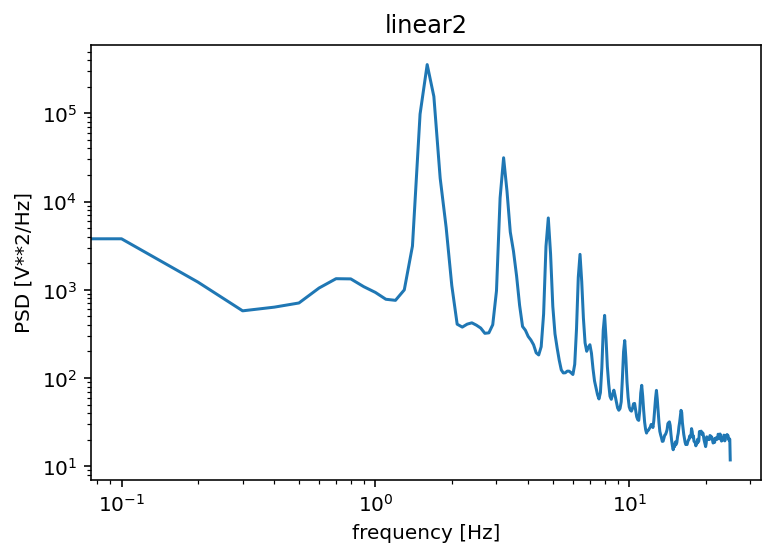

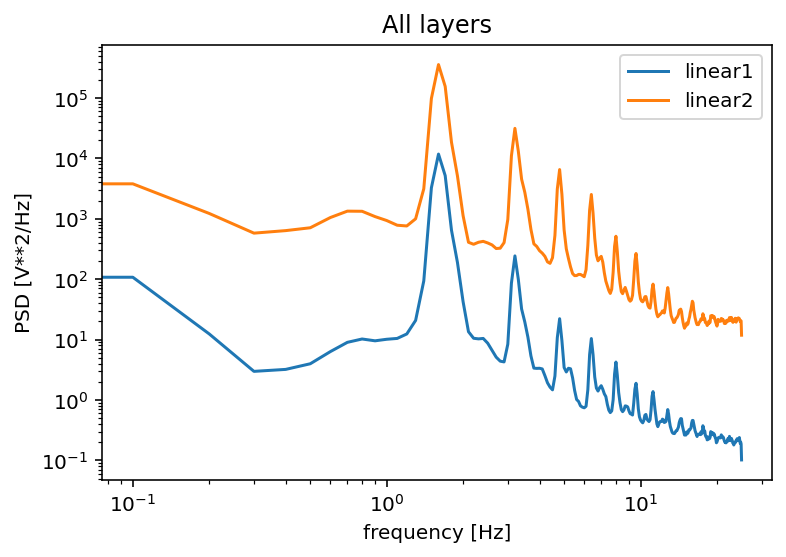

In [17]:
import scipy
from scipy import signal
# get the power spectral density of the pca of the activations
os.makedirs('psd', exist_ok=True)

k = 10
psd_trajectory_dict = {}
for name, activations in filtered_activations.items():
    # get the pca of the activations to k dimensions
    pca = PCA(n_components=k)
    pca.fit(activations)
    activations_pca = pca.transform(activations)  # (num_episodes_to_run * num_steps_per_episode, k)

    activations_reshaped = activations_pca.reshape(num_episodes_to_run, num_steps_per_episode,
                                                   -1)  # (episodes, steps, k)
    f, psd = scipy.signal.welch(activations_reshaped, fs=50, nperseg=500, noverlap=250, axis=-2)

    psd_pca = np.average(psd, axis=-1, weights=pca.explained_variance_ratio_)  # (episodes, steps)
    psd_trajectory = np.mean(psd_pca, axis=0)  # (steps,)

    psd_trajectory_dict[name] = psd_trajectory

    # make a plot of the power spectral density
    fig, ax = plt.subplots()
    ax.semilogy(f, psd_trajectory)
    ax.set_title(name)
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('PSD [V**2/Hz]')
    # set x scale to log
    ax.set_xscale('log')

    save_path = 'psd/{}.png'.format(name)
    # save_path = None
    fig_im = fig2img(fig)
    if save_path is not None:
        fig_im.save(save_path)

# make a plot of the power spectral density of all the layers from psd_trajectory_dict
fig, ax = plt.subplots()
for name, psd_trajectory in psd_trajectory_dict.items():
    ax.semilogy(f, psd_trajectory, label=name)
ax.set_title('All layers')
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('PSD [V**2/Hz]')
# set x scale to log
ax.set_xscale('log')
ax.legend()

save_path = 'psd/all_layers.png'
# save_path = None
fig_im = fig2img(fig)
if save_path is not None:
    fig_im.save(save_path)

### Task: Implement PCA / PSD over kinematics

In [18]:
def plot_pca(X, name):
    """
    Helper function that plot the data using dimensionality reduction method
    """
    os.makedirs("pca/", exist_ok=True)
    pca = PCA(n_components=2)
    trans = pca.fit_transform(X)
    plt.scatter(trans[:, 0], trans[:, 1], s=1)
    plt.title(name)
    plt.xlabel("First PC")
    plt.ylabel("Second PC")
    plt.savefig(f"pca/{name}.png", dpi=200)
    

We can see that there are periodic patterns in the PCA image of the X axis, which indicates that it is coordinating sequential periodic actions sequence between each geometric.

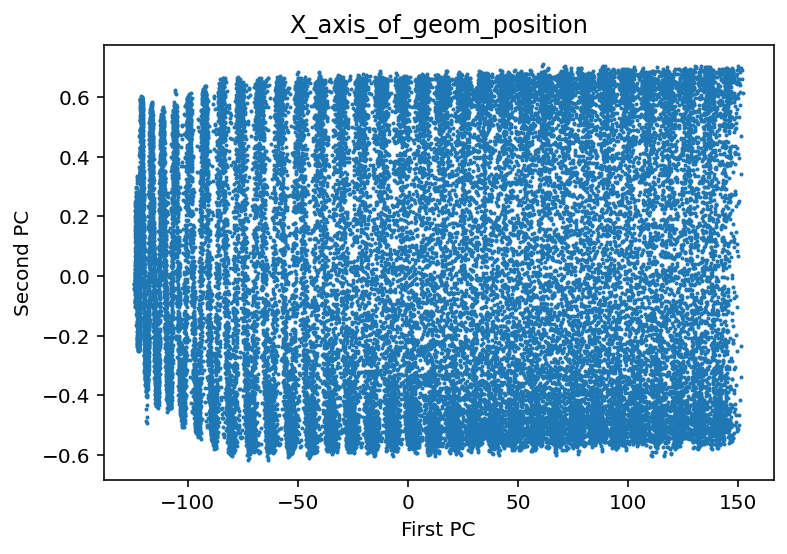

In [19]:
X = total_kinematic_dict["geom_positions"][:,:,0]
plot_pca(X, "X_axis_of_geom_position")

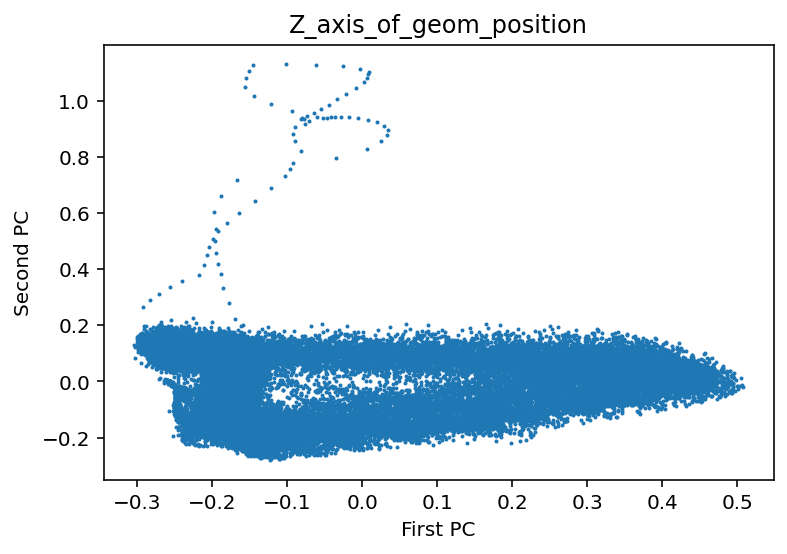

In [20]:
X = total_kinematic_dict["geom_positions"][:,:,2]
plot_pca(X, "Z_axis_of_geom_position")

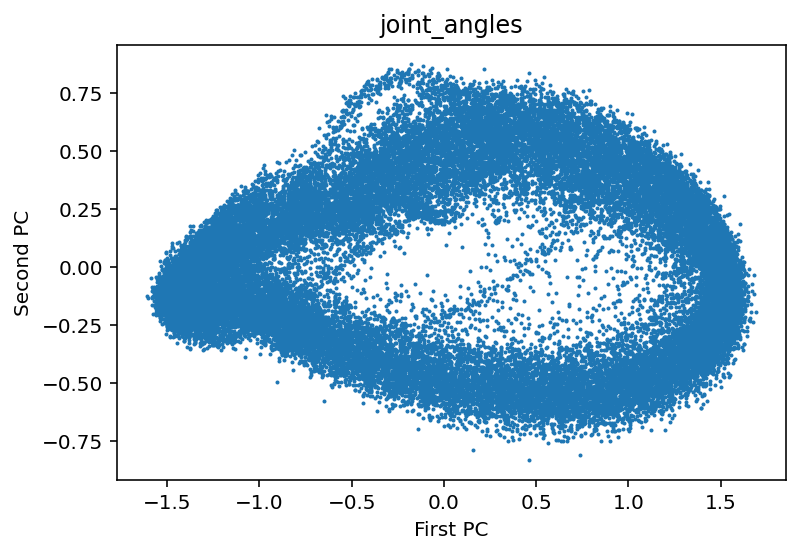

In [21]:
X = total_kinematic_dict["joint_angles"]
plot_pca(X, "joint_angles")

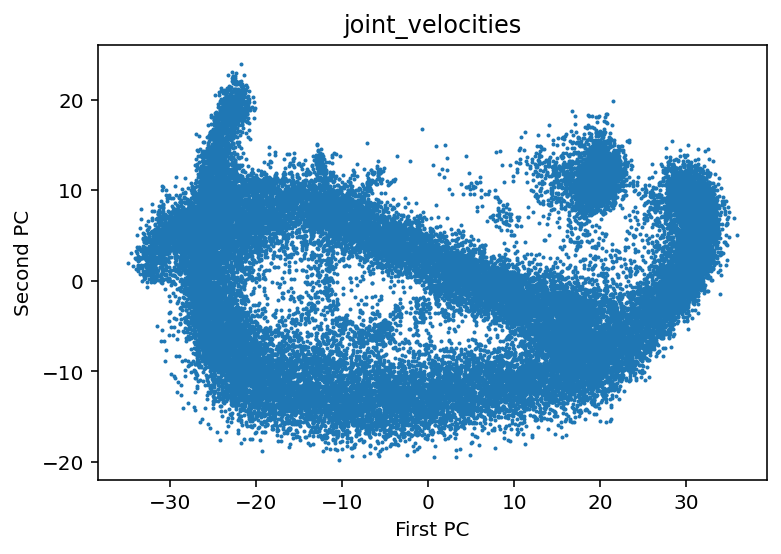

In [22]:
X = total_kinematic_dict["joint_velocities"]
plot_pca(X, "joint_velocities")

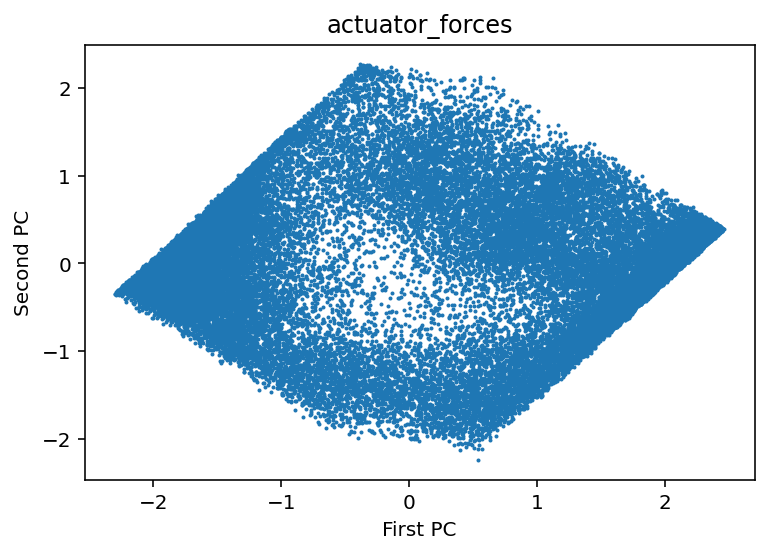

In [23]:
X = total_kinematic_dict["actuator_forces"]
plot_pca(X, "actuator_forces")

# Use tSNE to Cluster and visualize data 
`sklearn` provides implementation to tSNE in manifold package.

In [24]:
def plot_tsne(trans, name):
    os.makedirs("tsne/", exist_ok=True)
    plt.scatter(trans[:, 0], trans[:, 1], s=1)
    plt.title(name)
    plt.savefig(f"tsne/{name}.png", dpi=200)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


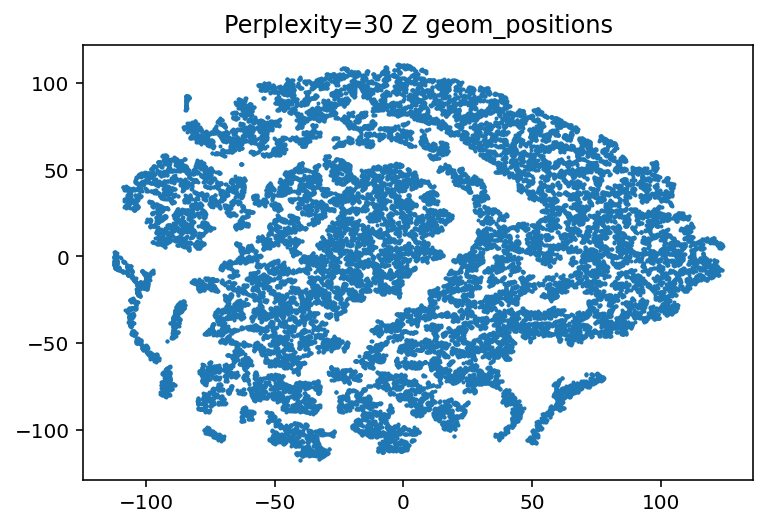

In [32]:
from sklearn.manifold import TSNE

X = total_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", n_jobs=-1)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=30 Z geom_positions")

/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


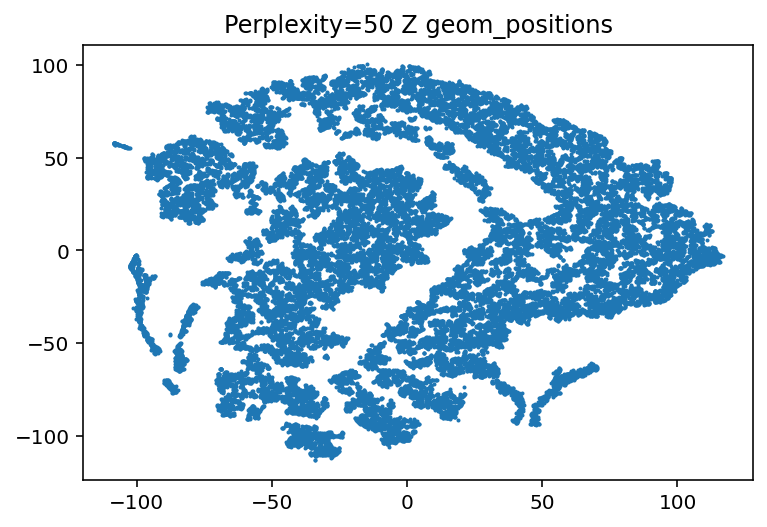

In [34]:
X = total_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=50, n_jobs=-1)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=50 Z geom_positions")

In [49]:
x = trans[:,0]
y = trans[:,1]

In [50]:
from sklearn.cluster import KMeans
import numpy as np

In [51]:
kmeans = KMeans(n_clusters=2, random_state=42)

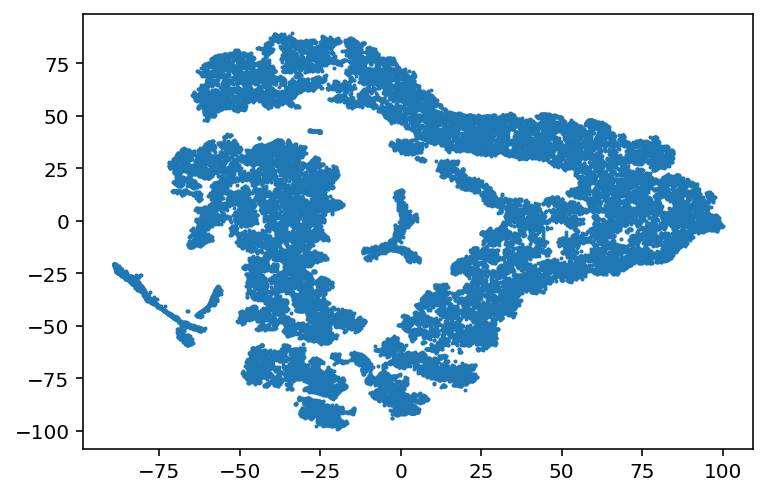

In [55]:
plt.scatter(x, y, s=1)

In [53]:
kmeans.fit(trans)

KMeans(n_clusters=2, random_state=42)

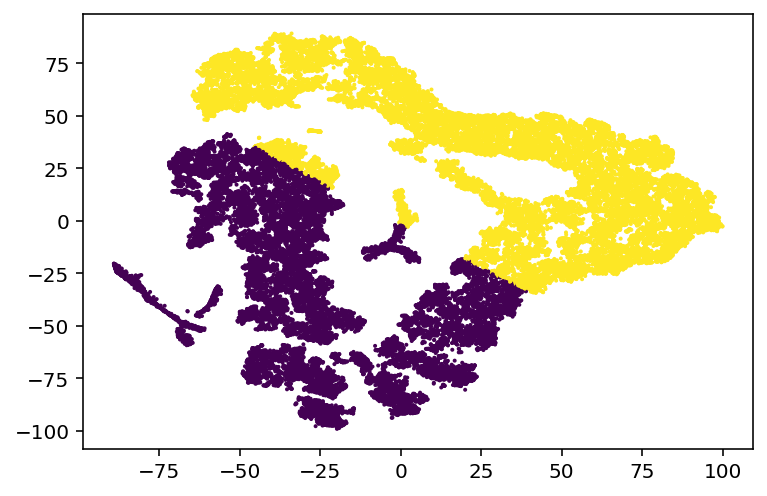

In [56]:
plt.scatter(x, y, c = kmeans.labels_, s=1)

/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


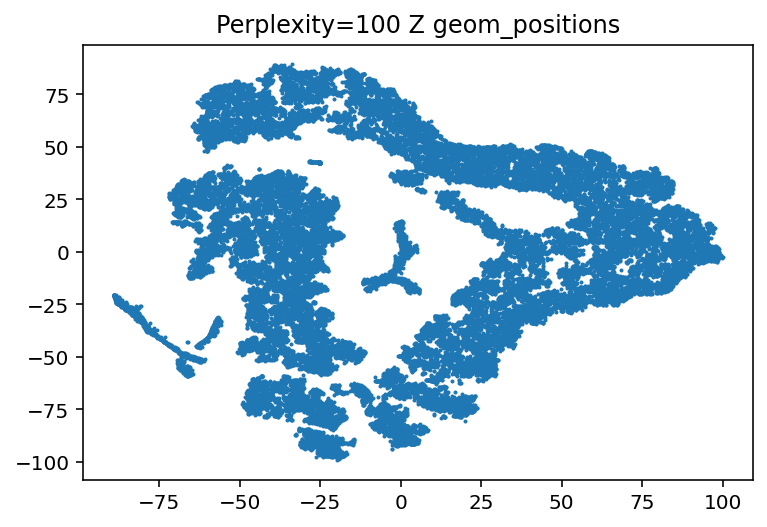

In [36]:
X = total_kinematic_dict["geom_positions"][:,:,2]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=100, n_jobs=-1)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=100 Z geom_positions")

/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


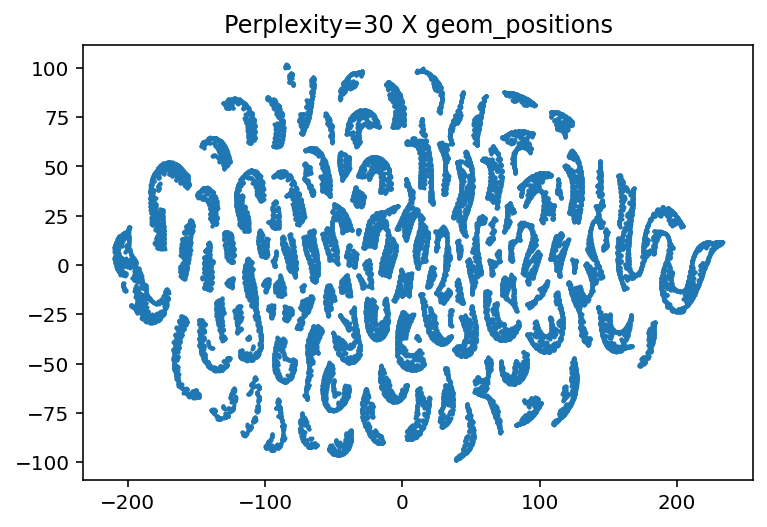

In [27]:
X = total_kinematic_dict["geom_positions"][:,:,0]
tsne = TSNE(init="pca",learning_rate="auto", n_jobs=-1)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=30 X geom_positions")

/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


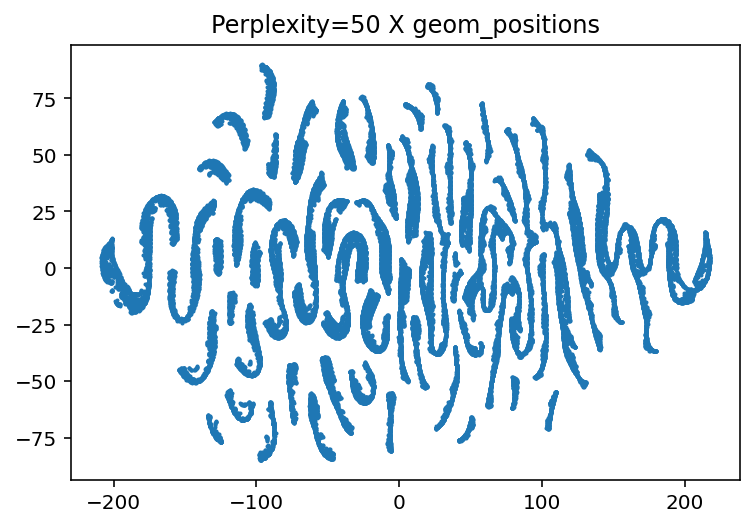

In [28]:
X = total_kinematic_dict["geom_positions"][:,:,0]
tsne = TSNE(init="pca",learning_rate="auto", perplexity=50, n_jobs=-1)
trans = tsne.fit_transform(X)
plot_tsne(trans, "Perplexity=50 X geom_positions")

## Plot in a live loop

In [29]:
hook_dict;

In [30]:
!pip install imageio-ffmpeg

Defaulting to user installation because normal site-packages is not writeable


In [31]:
# plot a single point

time_step = env.reset()
episode_len = 0
episode_reward = 0

# create an imageio writer to a mp4
writer = imageio.get_writer('test_combined_embedding_cheetah.mp4', fps=50)

# first, clear the hooks
clear_hook_dict(hook_dict)

while not time_step.last():
    # get the state
    state = get_flat_obs(time_step)
    # sample an action
    action = agent.select_action(state)
    # step the environment
    time_step = env.step(action)

    # record from a camera
    stitched_img = create_stitched_img(env)

    # get the latest dimension and do pca
    for name, hook_list in hook_dict.items():
        latest_activation = hook_list[-1]
        point = latest_activation.detach().cpu().numpy().reshape(1, -1)
        pca = pca_dict[name]
        # grab corresponding activations
        activations = activations_dict[name]

        # plot single point
        img = plot_single_point(point=point, activations=activations, pca=pca, layer_name=name)

        # combine the two images
        stitched_img = np.concatenate((img, stitched_img), axis=1)

        # img_arr.append(combined_img)

    # write to the writer
    writer.append_data(stitched_img)

    # logging stuff
    episode_reward += time_step.reward
    episode_len += 1

    # # clear the hooks for memory purposes?
    # clear_hook_dict(hook_dict)

# close the writer
writer.close()

print('episode stats:', 'episode_len:', episode_len, 'episode_reward:', episode_reward)

episode stats: episode_len: 1000 episode_reward: 916.0016821101308
